<a href="https://colab.research.google.com/github/ImtiazAhammad/Explainable-AI-over-Customly-Configured-GPT-2-for-Classification-Problem/blob/main/LRP_GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.1 MB/s eta 0:00:00


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import GPT2Model, GPT2Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from captum.attr import LayerIntegratedGradients, TokenReferenceBase
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/DTST/TruthSeeker_700.csv')

In [ ]:
df.head()

,1,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
0,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree
1,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree
2,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree
3,5,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree
4,6,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree


In [ ]:

# Split the dataset
train_text, temp_text, train_labels, temp_labels = train_test_split(df['tweet'], df['BinaryNumTarget'], random_state=2018, test_size=0.3, stratify=df['target'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)


In [ ]:
# Initialize GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_base_model = GPT2Model.from_pretrained('gpt2')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:

# Custom GPT-2 model
class GPT2_Classifier(nn.Module):
    def __init__(self, gpt2_model):
        super(GPT2_Classifier, self).__init__()
        self.gpt2 = gpt2_model
        self.fc = nn.Linear(self.gpt2.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0][:, -1, :]
        logits = self.fc(sequence_output)
        return logits

model = GPT2_Classifier(gpt2_base_model).to(device)


In [ ]:
# Tokenization and encoding
MAX_LENGTH = 50
def tokenize_and_encode(text):
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    return tokenizer.batch_encode_plus(
        text.tolist(),
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

tokens_train = tokenize_and_encode(train_text)
tokens_val = tokenize_and_encode(val_text)
tokens_test = tokenize_and_encode(test_text)

train_seq = tokens_train['input_ids']
train_mask = tokens_train['attention_mask']
train_y = torch.tensor(train_labels.tolist())

val_seq = tokens_val['input_ids']
val_mask = tokens_val['attention_mask']
val_y = torch.tensor(val_labels.tolist())

test_seq = tokens_test['input_ids']
test_mask = tokens_test['attention_mask']
test_y = torch.tensor(test_labels.tolist())

# DataLoader
batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


In [ ]:
from transformers import AdamW

In [ ]:
# Optimizer and Loss
optimizer = AdamW(model.parameters(), lr=1e-5)
cross_entropy = nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        labels = labels.long()
        optimizer.zero_grad()
        preds = model(sent_id, mask).float()
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

def evaluate():
    model.eval()
    total_loss = 0
    for batch in val_dataloader:
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        labels = labels.long()
        with torch.no_grad():
            preds = model(sent_id, mask).float()
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

# Training Loop
epochs = 4
for epoch in range(epochs):
    train_loss = train()
    valid_loss = evaluate()
    print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.3f} | Validation Loss: {valid_loss:.3f}')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4 | Train Loss: 1.405 | Validation Loss: 0.789
Epoch 2/4 | Train Loss: 0.742 | Validation Loss: 0.619
Epoch 3/4 | Train Loss: 0.568 | Validation Loss: 0.544
Epoch 4/4 | Train Loss: 0.353 | Validation Loss: 0.341


In [ ]:
torch.save(model.state_dict(), 'gpt2_tweet_classifier.pt')

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

model.load_state_dict(torch.load('gpt2_tweet_classifier.pt'))
model.eval()

predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs = model(b_input_ids, b_input_mask)
        logits = outputs.detach().cpu().numpy()
        predictions.append(logits)

predictions = np.concatenate(predictions, axis=0)
preds = np.argmax(predictions, axis=1)
print(classification_report(test_y.numpy(), preds))


              precision    recall  f1-score   support

           0       0.97      0.70      0.82       105
           1       0.77      0.98      0.86       105

    accuracy                           0.84       210
   macro avg       0.87      0.84      0.84       210
weighted avg       0.87      0.84      0.84       210



In [ ]:
df.tail()

,1,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
1394,1396,Tom Kertscher,Joe Bidens great-grandfather Joseph J. Biden w...,False,0,"Biden, great grandfather, slave owner",Joe Biden's family owned African slaves....\n\...,Mostly Agree,Agree
1395,1397,Tom Kertscher,Joe Bidens great-grandfather Joseph J. Biden w...,False,0,"Biden, great grandfather, slave owner","Joe Bidens great, great grandfather was a slav...",Agree,Agree
1396,1398,Tom Kertscher,Joe Bidens great-grandfather Joseph J. Biden w...,False,0,"Biden, great grandfather, slave owner","@ChevyChaseToGo ""Joe Bidens great-grandfather ...",Mostly Agree,Agree
1397,1399,Tom Kertscher,Joe Bidens great-grandfather Joseph J. Biden w...,False,0,"Biden, great grandfather, slave owner",@JoeBiden Facts are Bidens VP Kamala Harris Gr...,NO MAJORITY,Agree
1398,1400,Tom Kertscher,Joe Bidens great-grandfather Joseph J. Biden w...,False,0,"Biden, great grandfather, slave owner",@sunny Yes representation matters. Did you kno...,Agree,Agree


In [ ]:
df['tweet'][710], df['target'][710]

('@DaleBurnay Personally I do not feel positivity rate is a big deal because people are in many cases only going for testing once they are not feeling well\nI have sat for 8 hours watching the Moose Jaw testing centre and I did not witness a run on the place - even when they opened it up',
 False)

In [ ]:
def interpret_sentence(model, sentence, label=0):
    model.eval()
    input_ids = tokenizer.encode(sentence, add_special_tokens=True, return_tensors="pt")
    attention_mask = input_ids.ne(tokenizer.pad_token_id).type(torch.uint8)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    ref_input_ids = torch.full_like(input_ids, fill_value=tokenizer.pad_token_id)
    ref_attention_mask = torch.zeros_like(attention_mask)

    # Create a tuple of input tensors
    inputs = (input_ids, attention_mask)

    # Create a tuple of baseline tensors
    baselines = (ref_input_ids, ref_attention_mask)

    lig = LayerIntegratedGradients(model, model.gpt2.wte)

    # Ensure both inputs and baselines are tuples with the same structure
    attributions_ig = lig.attribute(inputs=inputs,
                                    baselines=baselines,
                                    additional_forward_args=None,
                                    target=label,
                                    return_convergence_delta=False)
    return attributions_ig

# Example LRP usage
sentence = "@DaleBurnay Personally I do not feel positivity rate is a big deal because people are in many cases only going for testing once they are not feeling well\nI have sat for 8 hours watching the Moose Jaw testing centre and I did not witness a run on the place - even when they opened it up."
attributions = interpret_sentence(model, sentence, label=1)


In [ ]:
attributions = interpret_sentence(model, sentence, label=1)


In [ ]:
# Convert attributions to numpy for easier processing
attributions_np = attributions[0].detach().cpu().numpy()

# Print shape for debugging
print("Attributions shape:", attributions_np.shape)

# Depending on the shape, adjust the axis for summation
if len(attributions_np.shape) == 3:
    # If 3 dimensions, sum across the embedding dimension
    attributions_sum = np.sum(attributions_np, axis=2).squeeze(0)
elif len(attributions_np.shape) == 2:
    # If 2 dimensions, sum across the last dimension
    attributions_sum = np.sum(attributions_np, axis=1)

# Normalize attributions for visualization
attributions_sum_norm = attributions_sum / np.linalg.norm(attributions_sum)

# Tokenize the input sentence to match tokens with their attributions
tokenized_sentence = tokenizer.tokenize(sentence)

# Display the tokens and their corresponding attributions
for token, attribution in zip(tokenized_sentence, attributions_sum_norm):
    print(f"Token: {token} \t Attribution: {attribution:.4f}")


Attributions shape: (64, 768)
Token: @ 	 Attribution: -0.0800
Token: D 	 Attribution: -0.0048
Token: ale 	 Attribution: 0.0494
Token: Burn 	 Attribution: 0.0396
Token: ay 	 Attribution: 0.0347
Token: ĠPersonally 	 Attribution: 0.0510
Token: ĠI 	 Attribution: 0.0183
Token: Ġdo 	 Attribution: 0.0449
Token: Ġnot 	 Attribution: 0.0588
Token: Ġfeel 	 Attribution: 0.0410
Token: Ġpos 	 Attribution: 0.0667
Token: itivity 	 Attribution: 0.2095
Token: Ġrate 	 Attribution: 0.0785
Token: Ġis 	 Attribution: -0.0193
Token: Ġa 	 Attribution: 0.0186
Token: Ġbig 	 Attribution: 0.0366
Token: Ġdeal 	 Attribution: 0.0820
Token: Ġbecause 	 Attribution: 0.0064
Token: Ġpeople 	 Attribution: 0.0642
Token: Ġare 	 Attribution: -0.0309
Token: Ġin 	 Attribution: 0.0165
Token: Ġmany 	 Attribution: 0.0574
Token: Ġcases 	 Attribution: 0.0465
Token: Ġonly 	 Attribution: 0.0229
Token: Ġgoing 	 Attribution: 0.0000
Token: Ġfor 	 Attribution: 0.0345
Token: Ġtesting 	 Attribution: -0.0338
Token: Ġonce 	 Attribution: -0.00

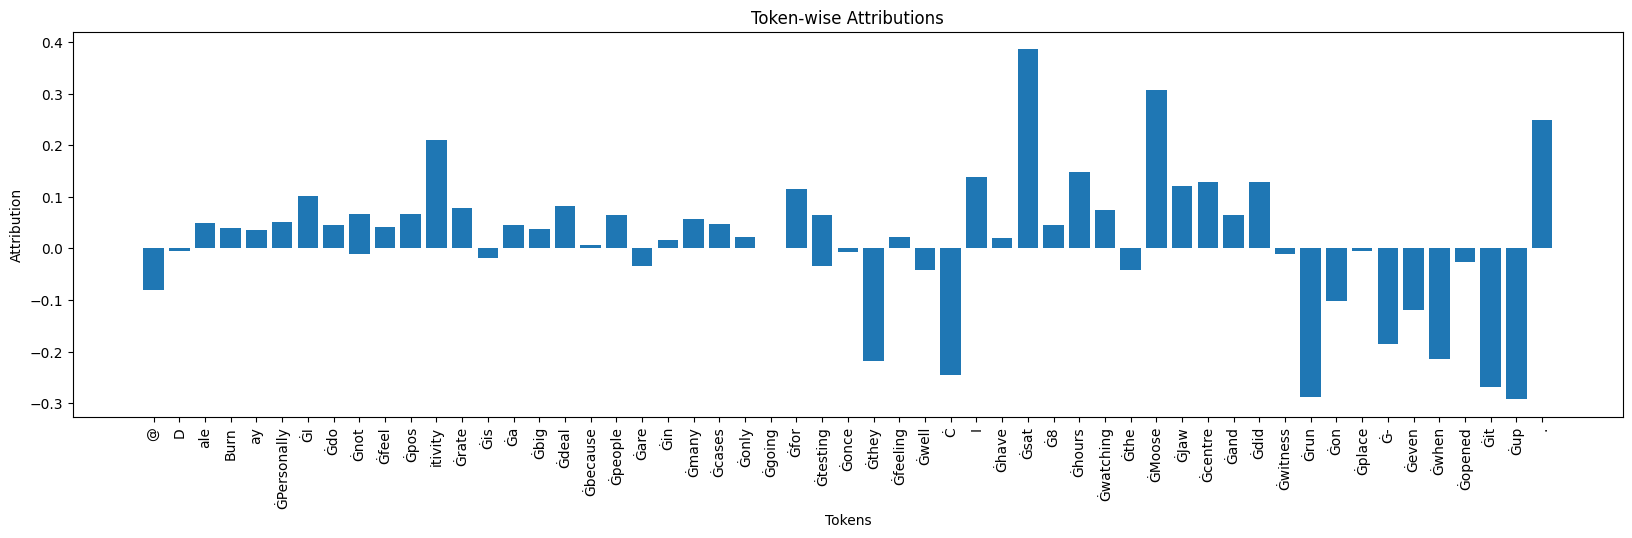

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.bar(tokenized_sentence, attributions_sum_norm)
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Attribution')
plt.title('Token-wise Attributions')
plt.show()


In [ ]:
df['tweet'][710], df['target'][710]

('@DaleBurnay Personally I do not feel positivity rate is a big deal because people are in many cases only going for testing once they are not feeling well\nI have sat for 8 hours watching the Moose Jaw testing centre and I did not witness a run on the place - even when they opened it up',
 False)

In [ ]:
df['statement'][710]

"The (COVID-19) cases are going up, but it's because the testing is going up."

In [ ]:
class GPT2_Classifier(nn.Module):
    def __init__(self, gpt2_model):
        super(GPT2_Classifier, self).__init__()
        self.gpt2 = gpt2_model
        self.fc = nn.Linear(self.gpt2.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask, return_attention=False):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask, output_attentions=return_attention)
        sequence_output = outputs[0][:, -1, :]
        logits = self.fc(sequence_output)

        if return_attention:
            attentions = outputs[-1]
            return logits, attentions
        else:
            return logits


In [ ]:
def get_attention_weights(model, sentence):
    input_ids = tokenizer.encode(sentence, return_tensors="pt", add_special_tokens=True)
    attention_mask = input_ids.ne(tokenizer.pad_token_id).type(torch.uint8)

    # Move to the same device as the model
    input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

    # Forward pass, return attention weights
    with torch.no_grad():
        _, attentions = model(input_ids, attention_mask, return_attention=True)

    return attentions


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(sentence, attentions):
    tokenized_sentence = tokenizer.tokenize(sentence)
    tokenized_sentence = ['CLS'] + tokenized_sentence + ['SEP']

    # Use attention from the last layer, last head
    attention = attentions[-1][0, -1].cpu().numpy()

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokenized_sentence, yticklabels=tokenized_sentence, cmap='viridis')
    plt.title("Attention Weights")
    plt.show()


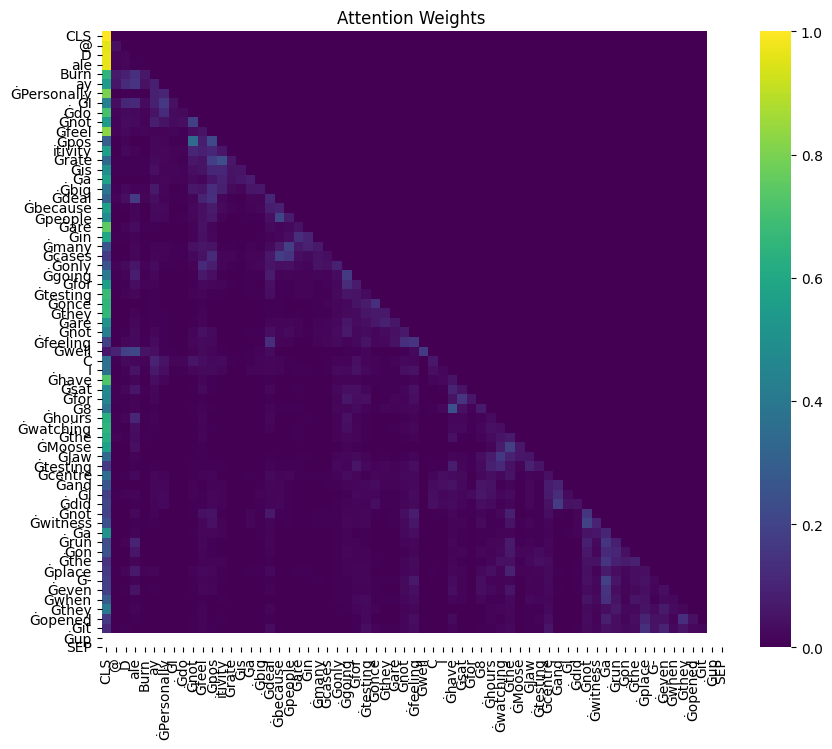

In [ ]:
# Example sentence
sentence = "@DaleBurnay Personally I do not feel positivity rate is a big deal because people are in many cases only going for testing once they are not feeling well\nI have sat for 8 hours watching the Moose Jaw testing centre and I did not witness a run on the place - even when they opened it up"

# Get attention weights
attentions = get_attention_weights(model, sentence)

# Visualize
visualize_attention(sentence, attentions)


In [ ]:
class GPT2_Classifier(nn.Module):
    def __init__(self, gpt2_model):
        super(GPT2_Classifier, self).__init__()
        self.gpt2 = gpt2_model
        self.fc = nn.Linear(self.gpt2.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask, return_attention=False):
        # Forward pass with option to return attention weights
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask, output_attentions=return_attention)
        sequence_output = outputs[0][:, -1, :]
        logits = self.fc(sequence_output)

        if return_attention:
            attentions = outputs[-1]
            return logits, attentions
        else:
            return logits


In [ ]:
def get_attention_weights(model, sentence):
    input_ids = tokenizer.encode(sentence, return_tensors="pt", add_special_tokens=True)
    attention_mask = input_ids.ne(tokenizer.pad_token_id).type(torch.uint8)

    # Move to the same device as the model
    input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

    # Forward pass, return attention weights
    with torch.no_grad():
        _, attentions = model(input_ids, attention_mask, return_attention=True)

    return attentions


In [ ]:
model = GPT2_Classifier(gpt2_base_model).to(device)


In [ ]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 9.6 MB/s eta 0:00:00


In [ ]:
import shap
import torch


In [ ]:
import shap

# Function to predict the outputs for SHAP
def model_predict(texts):
    # Convert texts to a format suitable for the model
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits

    # Convert logits to probabilities (optional)
    probabilities = torch.softmax(logits, dim=-1).cpu().numpy()
    return probabilities

# Initialize SHAP explainer
explainer = shap.Explainer(model_predict, tokenizer)


In [ ]:
# Example sentence for SHAP analysis
sentence = "@DaleBurnay Personally I do not feel positivity rate is a big deal because people are in many cases only going for testing once they are not feeling well\nI have sat for 8 hours watching the Moose Jaw testing centre and I did not witness a run on the place - even when they opened it up"

# Compute SHAP values
shap_values = explainer([sentence])

# Visualize the SHAP values
shap.plots.text(shap_values[0])


ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
# Initialize SHAP explainer
explainer = shap.Explainer(model_predict, tokenizer)

# Example sentence for SHAP analysis
sentence = "DaleBurnay Personally I do not feel positivity rate is a big deal because people are in many cases only going for testing once they are not feeling well\nI have sat for 8 hours watching the Moose Jaw testing centre and I did not witness a run on the place - even when they opened it up"

# Compute SHAP values
shap_values = explainer([sentence])  # Ensure this is a list of strings

# Visualize the SHAP values
shap.plots.text(shap_values[0])


ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
!pip install shap
import shap


model = GPT2_Classifier(gpt2_base_model).to(device)

# Function for SHAP Prediction
def model_predict(text_data):
    # Preprocess text data correctly for the tokenizer
    if isinstance(text_data, str):
        text_data = [text_data]  # Convert a single string to a list
    elif isinstance(text_data, list):
        pass  # No action needed
    else:
        raise ValueError("Invalid input format for text data.")

    # Tokenize and predict
    inputs = tokenizer(text_data, padding=True, truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits

    # Convert logits to probabilities
    probabilities = torch.softmax(logits, dim=-1).cpu().numpy()
    return probabilities

# Initialize SHAP explainer with the model predict function
explainer = shap.Explainer(model_predict)

# Example usage
sentence1 = "Your example sentence here."

# Compute SHAP values
shap_values = explainer([sentence1])  # Ensure input is in a list

# Visualize the SHAP values
shap.plots.text(shap_values[0])


In [ ]:

predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs = model(b_input_ids, b_input_mask)
        logits = outputs.detach().cpu().numpy()
        predictions.append(logits)

predictions = np.concatenate(predictions, axis=0)
preds = np.argmax(predictions, axis=1)
print(classification_report(test_y.numpy(), preds))

# SHAP Integration
def model_predict(text_data):
    # Preprocess text data correctly for the tokenizer
    if not isinstance(text_data, list):
        text_data = [text_data]

    # Tokenize and predict
    inputs = tokenizer(text_data, padding=True, truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs.logits

    # Convert logits to probabilities
    probabilities = torch.softmax(logits, dim=-1).cpu().numpy()
    return probabilities

# Initialize SHAP explainer
explainer = shap.Explainer(model_predict)

# Example usage
sentence1 = "DaleBurnay Personally I do not feel positivity rate is a big deal because people are in many cases only going for testing once they are not feeling well\nI have sat for 8 hours watching the Moose Jaw testing centre and I did not witness a run on the place - even when they opened it up"

# Compute SHAP values
shap_values = explainer([sentence1])

# Visualize the SHAP values
shap.plots.text(shap_values[0])

              precision    recall  f1-score   support

           0       0.52      0.75      0.61       105
           1       0.54      0.30      0.38       105

    accuracy                           0.52       210
   macro avg       0.53      0.52      0.50       210
weighted avg       0.53      0.52      0.50       210



ValueError: masker cannot be None.